In [1]:
from pyspark.sql import SparkSession
from pyspark import pandas as ps
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F

In [2]:
import matplotlib.pyplot as plt
import time
plt.rc('figure', figsize=(18, 4))
import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("analysis-uber-trip-data")
         .getOrCreate())

In [5]:
df = (spark.read
  .format("jdbc")
  .option("url", "jdbc:postgresql://localhost/Uber")
  .option("driver", "org.postgresql.Driver")
  .option("dbtable", "UBER")
  .option("user", "postgres")
  .option("password", "12345")
  .load()
)
print((df.count(), len(df.columns)))
df.show(10)

(385663, 8)
+--------------------+-------------------+-----+--------+--------+---------+--------------------+-------------+
|                  id|           datetime|price|distance|latitude|longitude|              source|  destination|
+--------------------+-------------------+-----+--------+--------+---------+--------------------+-------------+
|4da07de9-4b22-40a...|2018-12-13 09:20:05|  8.5|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|
|6dec3748-fd91-425...|2018-12-13 09:20:05| 14.0|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|
|cee1694c-aceb-4f3...|2018-12-15 16:25:07| null|    2.48| 42.3647| -71.0542|         Beacon Hill|South Station|
|27f7b6a6-3b7f-486...|2018-12-16 11:40:11| 15.0|    1.64| 42.3505| -71.1054|Northeastern Univ...|     Back Bay|
|6eba3a53-6bde-431...|2018-12-16 11:40:11| 11.5|    1.64| 42.3505| -71.1054|Northeastern Univ...|     Back Bay|
|8b251038-4be9-45f...|2018-12-16 11:40:11|  8.0|    1.64| 42.3505| -71.1054|Northeastern Uni

1. Exploratory Data Analysis

In [32]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df = df.dropna()
df = df.drop(col('id'))

+---+--------+-----+--------+--------+---------+------+-----------+
| id|datetime|price|distance|latitude|longitude|source|destination|
+---+--------+-----+--------+--------+---------+------+-----------+
|  0|       0|55095|       0|       0|        0|     0|          0|
+---+--------+-----+--------+--------+---------+------+-----------+



In [33]:
def createDataset(df: DataFrame):
  df = (df.withColumn("month", month("datetime"))
        .withColumn("hour", hour("datetime"))
        .withColumn("day", dayofmonth("datetime"))
        .withColumn("weekday", date_format("datetime", "EEEE")))
  return df

In [34]:
dataset = createDataset(df)
dataset.show(5)

+-------------------+-----+--------+--------+---------+--------------------+-------------+-----+----+---+--------+
|           datetime|price|distance|latitude|longitude|              source|  destination|month|hour|day| weekday|
+-------------------+-----+--------+--------+---------+--------------------+-------------+-----+----+---+--------+
|2018-12-13 09:20:05|  8.5|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|   12|   9| 13|Thursday|
|2018-12-13 09:20:05| 14.0|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|   12|   9| 13|Thursday|
|2018-12-16 11:40:11| 15.0|    1.64| 42.3505| -71.1054|Northeastern Univ...|     Back Bay|   12|  11| 16|  Sunday|
|2018-12-16 11:40:11| 11.5|    1.64| 42.3505| -71.1054|Northeastern Univ...|     Back Bay|   12|  11| 16|  Sunday|
|2018-12-16 11:40:11|  8.0|    1.64| 42.3505| -71.1054|Northeastern Univ...|     Back Bay|   12|  11| 16|  Sunday|
+-------------------+-----+--------+--------+---------+--------------------+----

In [8]:
def getCounts(field):
  return ps.DataFrame(dataset.groupBy(field)
  .count().withColumnRenamed("count", "frequency")
  .orderBy('frequency'))

In [9]:
hrs = getCounts("hour")
hrs.plot.bar(x = "hour", y = "frequency")

In [10]:
wdays = getCounts("weekday")
wdays.plot.bar(x = "frequency", y = "weekday")

In [11]:
psDF = ps.DataFrame(df)

In [12]:
psDF.plot.scatter(x='latitude', y='price')

C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



In [13]:
psDF.plot.scatter(x='longitude', y='price')

C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



In [14]:
psDF.plot.scatter(x='distance', y='price')

C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



2. Clustering trip with location

In [15]:
feature_assembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
uber_assembled_df = feature_assembler.transform(df)
uber_assembled_df.show(10)

+--------------------+-------------------+-----+--------+--------+---------+--------------------+-------------+--------------------+
|                  id|           datetime|price|distance|latitude|longitude|              source|  destination|            features|
+--------------------+-------------------+-----+--------+--------+---------+--------------------+-------------+--------------------+
|4da07de9-4b22-40a...|2018-12-13 09:20:05|  8.5|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|[42.3518981933593...|
|6dec3748-fd91-425...|2018-12-13 09:20:05| 14.0|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|[42.3518981933593...|
|cee1694c-aceb-4f3...|2018-12-15 16:25:07| null|    2.48| 42.3647| -71.0542|         Beacon Hill|South Station|[42.3647003173828...|
|27f7b6a6-3b7f-486...|2018-12-16 11:40:11| 15.0|    1.64| 42.3505| -71.1054|Northeastern Univ...|     Back Bay|[42.3504981994628...|
|6eba3a53-6bde-431...|2018-12-16 11:40:11| 11.5|    1.64| 42.3505| -7

In [16]:
train_df, test_df = uber_assembled_df.randomSplit([0.7, 0.3], seed=42)
kmeans = KMeans(k=8, initMode='k-means||', featuresCol='features', predictionCol='cluster', maxIter=10)
kmModel = kmeans.fit(train_df)
print("KMeans Cluster Centers: ")
for center in kmModel.clusterCenters():
    print(center)

KMeans Cluster Centers: 
[ 42.33980179 -71.08920288]
[ 42.21480179 -71.03299713]
[ 42.35265316 -71.05917495]
[ 42.36470032 -71.05419922]
[ 42.35029984 -71.08100128]
[ 42.34717141 -71.10316886]
[ 42.36557844 -71.06402244]
[ 42.35879898 -71.0707016 ]


In [18]:
test_preds = kmModel.transform(uber_assembled_df)
test_preds.show(10)

+--------------------+-------------------+-----+--------+--------+---------+--------------------+-------------+--------------------+-------+
|                  id|           datetime|price|distance|latitude|longitude|              source|  destination|            features|cluster|
+--------------------+-------------------+-----+--------+--------+---------+--------------------+-------------+--------------------+-------+
|4da07de9-4b22-40a...|2018-12-13 09:20:05|  8.5|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|[42.3518981933593...|      2|
|6dec3748-fd91-425...|2018-12-13 09:20:05| 14.0|    2.48| 42.3519| -71.0551|         Beacon Hill|South Station|[42.3518981933593...|      2|
|cee1694c-aceb-4f3...|2018-12-15 16:25:07| null|    2.48| 42.3647| -71.0542|         Beacon Hill|South Station|[42.3647003173828...|      3|
|27f7b6a6-3b7f-486...|2018-12-16 11:40:11| 15.0|    1.64| 42.3505| -71.1054|Northeastern Univ...|     Back Bay|[42.3504981994628...|      5|
|6eba3a53-6bd

In [19]:
names = []
listname = (test_preds.select("cluster", "source")
        .groupBy("cluster")
        .agg(F.collect_set("source").alias("source")))
listname = listname.toPandas()
for index, row in listname.iterrows():
  for name in row["source"]:
    if name not in names:
      listname.at[index, "source"] = name
      names.append(name)
      break
name = spark.createDataFrame(listname)

C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [20]:
freq = (test_preds
    .select(F.hour("datetime").alias("hour"), "cluster")
    .groupBy(["hour", "cluster"])
    .count()
    .orderBy(F.desc("count")))

location = freq.join(name, freq.cluster == name.cluster, "inner")
location.show(10)

+----+-------+-----+-------+---------+
|hour|cluster|count|cluster|   source|
+----+-------+-----+-------+---------+
|  13|      1| 3813|      1|North End|
|   4|      1| 3225|      1|North End|
|  14|      1|  983|      1|North End|
|  23|      1| 5125|      1|North End|
|  21|      1| 3836|      1|North End|
|   0|      1|  483|      1|North End|
|  16|      1| 2116|      1|North End|
|   2|      1| 3921|      1|North End|
|   8|      1| 2258|      1|North End|
|  10|      1| 1038|      1|North End|
+----+-------+-----+-------+---------+
only showing top 10 rows



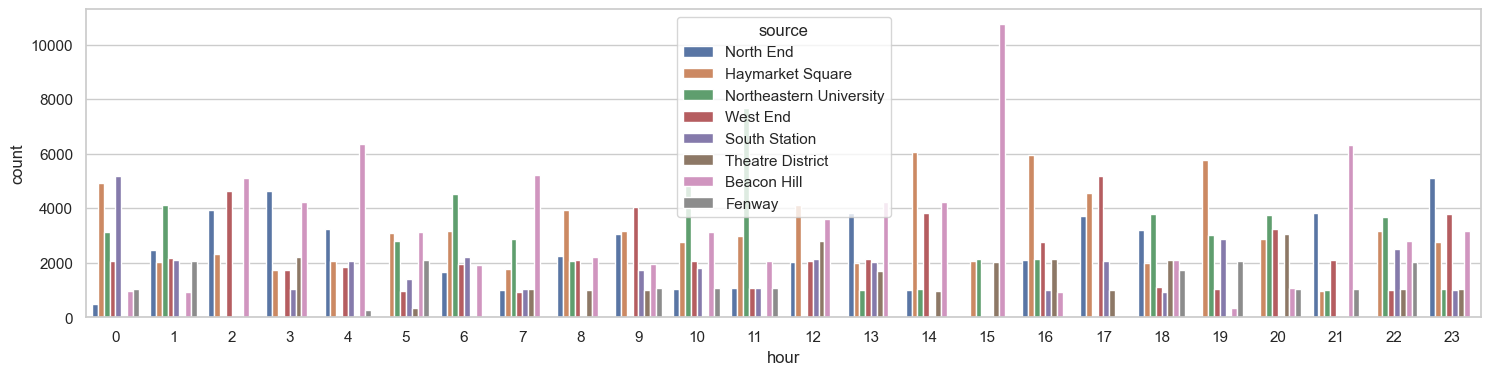

In [21]:
plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", hue="source", data= location.toPandas());

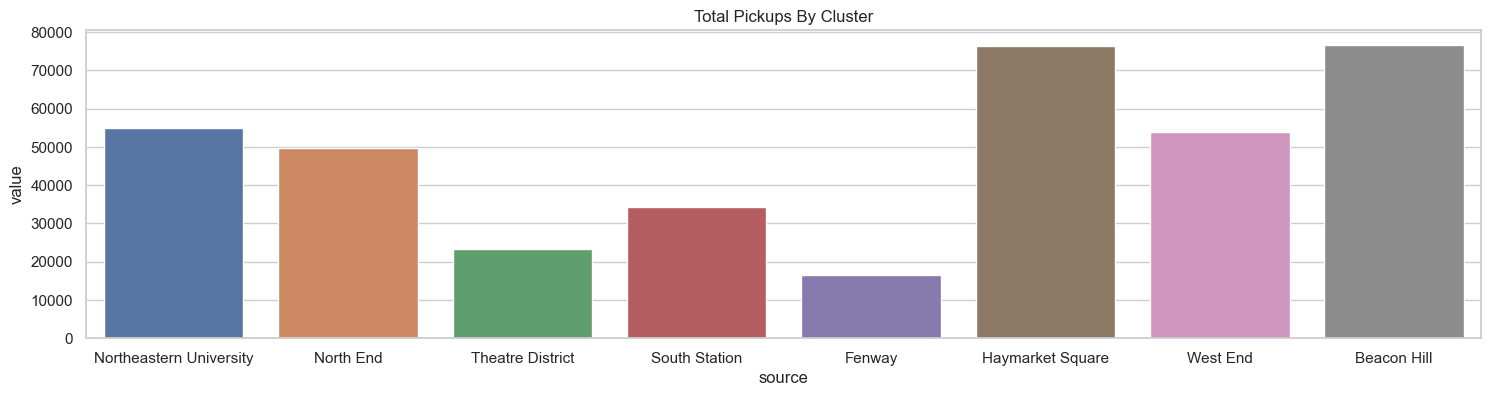

In [22]:
freq_cluster = (location.groupBy("source")
                  .agg(sum("count").alias("value")))
plt.figure(figsize=(18, 4))
sns.barplot(x="source", y="value", data= freq_cluster.toPandas())
plt.title("Total Pickups By Cluster");

3. Build one model to predict price

In [35]:
(trainingDataRF, testData) = dataset.randomSplit([0.7, 0.3])

In [36]:
assembler = VectorAssembler(inputCols=["distance", "month", "hour", "day"], outputCol="features")
rf = RandomForestRegressor(labelCol="price", featuresCol="features")
pipeline = Pipeline(stages=[assembler, rf])

In [37]:
model = pipeline.fit(trainingDataRF)

predictions = model.transform(testData)

predictions.select("prediction", "price", "features").show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
|13.183853687893649|  7.0|[0.56000000238418...|
|15.209505137476649|  8.0|[2.19000005722045...|
|17.394662662357177|  8.5|[2.61999988555908...|
|17.431601495451005|  9.5|[2.66000008583068...|
|17.431601495451005| 10.0|[2.66000008583068...|
+------------------+-----+--------------------+
only showing top 5 rows



In [38]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only

Root Mean Squared Error (RMSE) on test data = 8.06722
RandomForestRegressionModel: uid=RandomForestRegressor_ce46b423322f, numTrees=20, numFeatures=4


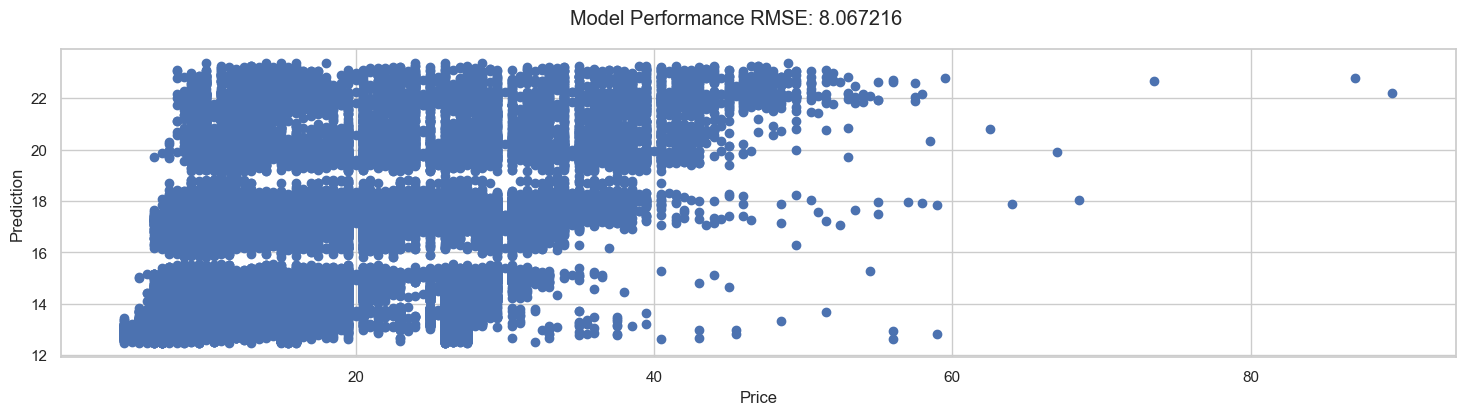

In [39]:
rfResult = predictions.select("price", "prediction").toPandas()
plt.plot(rfResult.price, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

4. Demo spark streaming kafka

In [40]:
schema = StructType([
    StructField("id", StringType(), nullable=False),
    StructField("datetime", StringType(), nullable=False),
    StructField("distance", DoubleType(), nullable=False),
    StructField("latitude", DoubleType(), nullable=False),
    StructField("longitude", DoubleType(), nullable=False),
    StructField("source", StringType(), nullable=False),
    StructField("destination", StringType(), nullable=False)]
  )

In [41]:
dfStream = (spark
  .readStream
  .format("kafka")
  .option("kafka.bootstrap.servers", "localhost:9092")
  .option("subscribe", "uber")
  .option("startingOffsets", "latest")
  .option("failOnDataLoss", "false")
  .load())
dfStream.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [54]:
dfStream = dfStream.selectExpr("CAST(value AS STRING)")
dataStream = dfStream.select(from_json(col("value"), schema).alias("data")).select("data.*")
dataStream = dataStream.dropDuplicates()

In [55]:
realData = createDataset(dataStream)
trans_data = model.transform(realData)

In [56]:
predictedData = trans_data.drop("month", "hour", "day", "weekday", "features")

In [ ]:
query = (predictedData.writeStream
      .format("csv")
      .outputMode("append")
      .option("header", True)
      .trigger(processingTime="5 seconds")
      .option("path", "C:/Users/Test/Downloads/Bigdata/Bigdata/test")
      .option("checkpointLocation", "C:/Users/Test/Downloads/Bigdata/Bigdata/test")
      .start())

In [19]:
def foreach_batch_function(df, epoch_id):
  (df.write
   .mode('append')
  .format("jdbc")
  .option("url", "jdbc:postgresql://localhost/Uber")
  .option("driver", "org.postgresql.Driver")
  .option("dbtable", "test")
  .option("user", "postgres")
  .option("password", "12345")
  .save())
  

In [61]:
(predictedData.writeStream
.trigger(processingTime="2 seconds")
.foreachBatch(foreach_batch_function)
.start()
.awaitTermination(20))


False

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\py4j\clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\utils.py", line 272, in call
    raise e
  File "C:\Users\Test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\utils.py", line 269, in call
    self.func(DataFrame(jdf, self.session), batch_id)
  File "C:\Users\Test\AppData\Local\Temp\ipykernel_16896\3344050152.py", line 10, in foreach_batch_function
    .save())
  File "C:\Users\Test\AppData\Local\Packages\Py